In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

Using TensorFlow backend.
/home/bhaven/anaconda3/envs/Project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhaven/anaconda3/envs/Project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhaven/anaconda3/envs/Project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhaven/anac

In [3]:
keras.__version__

'2.2.5'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True, validation_split=0.1, preprocessing_function= preprocess_input)
train_generator = train_datagen.flow_from_directory('/home/bhaven/Downloads/hymenoptera_data/train',batch_size=32,target_size = (224, 224),class_mode = 'binary',subset = 'training')
test_generator = train_datagen.flow_from_directory('/home/bhaven/Downloads/hymenoptera_data/train',batch_size=32,target_size=(224, 224),class_mode='binary',subset='validation')

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
conv_base = keras.applications.VGG16(include_top = False, weights = 'imagenet')
for layer in conv_base.layers:
    layer.trainable = False

In [6]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [7]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])


In [8]:
history = model.fit_generator(generator=train_generator,steps_per_epoch=int(1800/32), epochs=25,validation_data=test_generator)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
56/56 [==============================] - 43s 762ms/step - loss: 0.7078 - acc: 0.5056 - val_loss: 0.6922 - val_acc: 0.5150
Epoch 2/25
56/56 [==============================] - 41s 738ms/step - loss: 0.7068 - acc: 0.4788 - val_loss: 0.6921 - val_acc: 0.4850
Epoch 3/25
56/56 [==============================] - 42s 756ms/step - loss: 0.6999 - acc: 0.4983 - val_loss: 0.6858 - val_acc: 0.5850
Epoch 4/25
56/56 [==============================] - 41s 734ms/step - loss: 0.7021 - acc: 0.5312 - val_loss: 0.7022 - val_acc: 0.5000
Epoch 5/25
56/56 [==============================] - 41s 734ms/step - loss: 0.7058 - acc: 0.4961 - val_loss: 0.6862 - val_acc: 0.5700
Epoch 6/25
56/56 [==============================] - 41s 733ms/step - loss: 0.7045 - acc: 0.5095 - val_loss: 0.6819 - val_acc: 0.5700
Epoch 7/25
56/56 [==============================] - 41s 737ms/step - loss: 0.7015 - acc: 0.5028 - val_loss: 

In [9]:
model.save('/home/bhaven/Desktop/model/diabetic.h5')

# architecture to JSON, weights to HDF5
model.save_weights('/home/bhaven/Desktop/model/weights.h5')
with open('/home/bhaven/Desktop/model/architecture.json', 'w') as f:
        f.write(model.to_json())

In [10]:
# architecture and weights from HDF5
model = load_model('/home/bhaven/Desktop/model/diabetic.h5')

# architecture from JSON, weights from HDF5
with open('/home/bhaven/Desktop/model/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('/home/bhaven/Desktop/model/weights.h5')

In [15]:
validation_img_paths = ["/home/bhaven/Desktop/img/1_right.jpeg",
                        "/home/bhaven/Desktop/img/1_left.jpeg",
                        "/home/bhaven/Desktop/img/6_right.jpeg",
                        "/home/bhaven/Desktop/img/6_left.jpeg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [16]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224)))) for img in img_list])

In [17]:
pred_probs = model.predict(validation_batch)

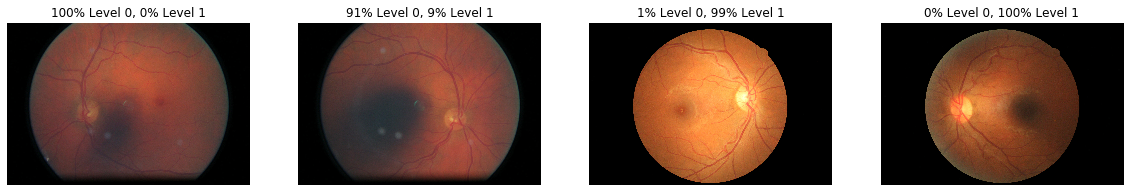

In [18]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Level 0, {:.0f}% Level 1".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)